In [1]:
import numpy as np
import sympy as sp
from IPython.display import display, Image
import itertools

## General FEM walk through

This example problem of a general Finite Element problem is from HW8 problem 5. This outlines the general process of implementing a FE approximation and obtaining a solution. The problem statement is as follows:
______________________________________________________________________________________________________________


### Problem 5

Write a finite element code to find the steady-state temperature distribution on a square rigid-body of side length a = 10.0, for which the boundary conditions are shown in the following figure. Assume that there is no heat supply per unit area. Specifically, solve the problem using four uniform meshes with a 

<img src="temp_distribution.png">

total number of 2×2, 4×4, 8×8, and 16×16 4-node square elements using exact integration for all element arrays. Submit a copy of the code including any input files. Plot contours of the computed temperature distribution throughout the body. The exact solution of the problem can be found in series form as: 

$$u(x,y) = \sum_{n=1}^{\infty} \frac{0.2}{\sinh n \pi} \biggl\{ \int_{0}^{10} z(10-z) \sin \frac{n \pi z}{10} dz \biggr \} \sin \frac{n \pi x}{10} \sinh \frac{n \pi (10-y)}{10}$$

Compute the exact solution at the center of the body $(x = 5, y = 5)$ and plot the error at this point as a function of the size h of the elements (use both decimal and log-log scale). Likewise, plot the $L_2$-norm $||u − uh||$ of the error over the whole domain as a function of $h$. Comment on the rate of convergence of the finite element solution.

______________________________________________________________________________________________________________

#### The governing equation:

Heat transfer is determined the Laplace equation:

$$ \frac{\partial}{\partial x_1} \biggl(k \frac{\partial u}{\partial x_1} \biggr) + \frac{\partial}{\partial x_2} \biggl(k \frac{\partial u}{\partial x_2}\biggr) = f$$

Through integration by parts and the divergence theorem, the weak form of the Laplace equation becomes:

$$ \int_{\Omega} \biggl[ \frac{\partial w}{\partial x_1} k \frac{\partial u}{\partial x_1} + \frac{\partial w}{\partial x_2} k \frac{\partial u}{\partial x_2} + wf \biggr] d\Omega + \int_{\Gamma_q} w \bar{q} d\Gamma = 0$$

The case of this problem, we are looking at the steady-state temperature distribution and with no heat source. Therefore the boundary conditions and forcing function are equal to zero. 

#### First determine the input parameters:

Since this is a temperature distribution problem, there is only __one degree of freedom__. Another way to think about this is that the mesh itself is not actually moving; the only variable that is changing is the temperature.

number of elements per side of mesh is given by __side__. 

Total number of elements in mesh is given by __numel__.

Total number of nodes in the mesh: __numnp__.

Nodes per element __nen__.

Nodes per side of mesh __node_side__. 

Length of one side of mesh __a__.


In [2]:
#input parameters
ndf = 1  # degrees of freedom                                                     
side = [2, 4, 8, 16]     #elements per side             
numel =[4, 16, 64, 256]  #total number of elements in mesh                                    
numnp = [(side[i]+1)**2 for i in range(len(numel))]   #total nodes for each mesh
nen = 4   #nodes per element                           
node_side = [3,5,9,17]   #nodes per side of mesh
a = 10   #lenght of one side

We now need to come up with an appropriate approximation function $u_h$. To do this we will need to create a quadrilateral mesh as stated in the example problem. The 2x2 square-element mesh is described and can be expanded for the 4x4, 8x8 and 16x16 element arrays as well. First label all of global nodes and elements:

<img src="temp_distribution_node.png">

Focusing on just a single element, we can construct shape functions that will serve as our $u_h$ and $w_h$ (Bubnov-Galerkin). In a 4-node element, the shape functions for each successive node are determined as:

$$N_i = \frac{1}{4}(1-x)(1-y)$$

$$N_{i+1} = \frac{1}{4}(1+x)(1-y)$$

$$N_{i+2} = \frac{1}{4}(1+x)(1+y)$$

$$N_{i+3} = \frac{1}{4}(1-x)(1+y)$$

Where $N_i$ is the shape function in each successive node of the element labeled by the global element. In the case of the 2x2 mesh, shape functions for the first element are: $N_1$, $N_2$, $N_5$, $N_4$. For the second element: $N_2$, $N_3$, $N_6$, $N_5$, etc.

A finite approximation is computed on the local level where each of the approximation function $u_h$ and weighting function $w_h$ are multiplied with each. This process is explained in _Panos FEM notes_ equations 3.24-3.30, where the final equation is $K \alpha = F$. The local stiffness matrix then is observed as follows:

$$ K_{ij} = \begin{bmatrix} \frac{\partial w_{h_1}}{\partial \xi} \frac{\partial u_{h_1}}{\partial \xi} + \frac{\partial w_{h_1}}{\partial \eta} \frac{\partial u_{h_1}}{\partial \eta} & .. & .. & \frac{\partial w_{h_1}}{\partial \xi} \frac{\partial u_{h_4}}{\partial \xi} + \frac{\partial w_{h_1}}{\partial \eta} \frac{\partial u_{h_4}}{\partial \eta}\\ .. & .. & .. & .. \\ \frac{\partial w_{h_4}}{\partial \xi} \frac{\partial u_{h_1}}{\partial \xi} + \frac{\partial w_{h_4}}{\partial \eta} \frac{\partial u_{h_1}}{\partial \eta}  & .. & .. & \frac{\partial w_{h_4}}{\partial \xi} \frac{\partial u_{h_4}}{\partial \xi} + \frac{\partial w_{h_4}}{\partial \eta} \frac{\partial u_{h_4}}{\partial \eta}  \end{bmatrix} $$

$$ K_{ij} = \begin{bmatrix} \frac{\partial N_1}{\partial \xi} \frac{\partial N_1}{\partial \xi} + \frac{\partial N_1}{\partial \eta} \frac{\partial N_1}{\partial \eta} & .. & .. & \frac{\partial N_1}{\partial \xi} \frac{\partial N_4}{\partial \xi} + \frac{\partial N_1}{\partial \eta} \frac{\partial N_4}{\partial \eta}\\ .. & .. & .. & .. \\ \frac{\partial N_4}{\partial \xi} \frac{\partial N_1}{\partial \xi} + \frac{\partial N_4}{\partial \eta} \frac{\partial N_1}{\partial \eta}  & .. & .. & \frac{\partial N_4}{\partial \xi} \frac{\partial N_4}{\partial \xi} + \frac{\partial N_4}{\partial \eta} \frac{\partial N_4}{\partial \eta}  \end{bmatrix} $$

In [3]:
xi, eta = sp.symbols('xi eta')

def shape(x,y):
    N1 = sp.Rational(1,4)*(1-x)*(1-y)
    N2 = sp.Rational(1,4)*(1+x)*(1-y)
    N3 = sp.Rational(1,4)*(1+x)*(1+y)
    N4 = sp.Rational(1,4)*(1-x)*(1+y)
    return [N1, N2, N3, N4]
shape_fn = shape(xi,eta)
shape_mat = sp.zeros(len(shape_fn))

# Create elemental K_ij matrix in symbolic form with sympy:
for j in range(len(shape_fn)):
    for i in range(len(shape_fn)):
        shape_mat[j,i] = sp.integrate(sp.integrate((sp.diff(shape_fn[i],xi)*sp.diff(shape_fn[j],xi) + 
                         sp.diff(shape_fn[i],eta)*sp.diff(shape_fn[j],eta)),(xi,-1,1)),(eta,-1,1))
        
        
# Convert symbolic form to numerical form with numpy
K_ij = np.reshape(shape_mat,(len(shape_fn),len(shape_fn)))

sp.pprint('[K_ij] :')     
print(K_ij)

[K_ij] :
[[2/3 -1/6 -1/3 -1/6]
 [-1/6 2/3 -1/6 -1/3]
 [-1/3 -1/6 2/3 -1/6]
 [-1/6 -1/3 -1/6 2/3]]


______________________________________________________________________________________________________________
It is important to note that our natural and physical domain are equal to each other -- in other words mesh consists of regular square elements. If the square elements of in the mesh consisted of irregular quadrilateral elements, we would need to develop parametric equations to map the natural domain (square elements) to the physical domain (irregular elements). For more details, see _Panos FEM notes_ 5.6.
______________________________________________________________________________________________________________

We now need a way to compute a global stiffness matrix that takes into account all of the nodes within the mesh. We can do this with 3 matrices $[\textbf{ID}]$, $[\textbf{IX}]$, and $[\textbf{LM}]$. In order to compute these matrices, it is advantageous from a coding point of view to generate matrices representing numbered global nodes in the varying mesh sizes.

In [4]:
#Create element matrix 
e_4 = np.zeros((side[0]+1,side[0]+1))
e_16 = np.zeros((side[1]+1,side[1]+1))
e_64 = np.zeros((side[2]+1,side[2]+1))
e_256 = np.zeros((side[3]+1,side[3]+1))
e = [e_4,e_16,e_64,e_256]


for z in range(len(e)):
    counter = 1
    for i in range(side[z]+1):
        for j in range(side[z]+1):
            e[z][i,j] = counter
            counter += 1       
#     print('element matrix {}'.format(z+1))
#     display(e[z])

print('Global nodes for 2x2 matrix:')
display(e[0])

Global nodes for 2x2 matrix:


array([[1., 2., 3.],
       [4., 5., 6.],
       [7., 8., 9.]])

Note: From a computation stand point, these nodal matrices are entered in in reverse of how the mesh is depicted. Compare the Globlal node matrix for 2x2 mesh above to the visual representation below. 

<img src="dof.png">

To construct the Assembly matrices $\textbf{A}$, first focus on $[\textbf{ID}]$ is a __ndfxnumnp__ matrix that is filled with the numbered degrees of freedom. The first column in the $[\textbf{ID}]$ is filled with numbered degrees of freedom for the first node, the second column for the second node, and so on. From the example from _Panos FEM notes_, the degrees of freedom at each node are a maximum of two, and depending on boundary conditions, less. The first node has boundary conditions applied and therefore have 0 degress of freedom so $[\textbf{ID}]$'s first column is filled with zeros.

$$[\textbf{ID}] = \begin{bmatrix} 0 & 1 & 3 & 5 & 7 & 0 & 12 & 14 \\ 0 & 2 & 4 & 6 & 8 & 10 & 13 & 15 \end{bmatrix}$$


In [5]:
"""Create the matrices IX, ID and LM"""

# ID matrices
ID_2 = sp.zeros(ndf,(side[0]+1)**2)
ID_4 = sp.zeros(ndf,(side[1]+1)**2)
ID_8 = sp.zeros(ndf,(side[2]+2)**2)
ID_16 = sp.zeros(ndf,(side[3]+2)**2)

ID = [ID_2, ID_4, ID_8, ID_16]

for n in range(len(ID)):
    for i in range(ndf):
        for j in range((side[n]+1)**2):
            ID[n][i,j] = j+1
print('ID_{2x2} = ')         
display(ID[0])
print('ID_{8x8} = ')         
display(ID[2])

matt = sp.zeros(5,5)

count = 1
for i in range(5):
    for j in range(5):
        matt[i,j] = count
        count += 1
# display(matt)

ID_{2x2} = 


Matrix([[1, 2, 3, 4, 5, 6, 7, 8, 9]])

ID_{8x8} = 


Matrix([[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

For this problem, there is only one degree of freedom (temperature) and 9 global nodes (for the 2x2) and 25 global nodes (for the 4x4). 

#### $[\textbf{IX}]$ matrix

The $[\textbf{IX}]$ matrix is a __nen x numel__ array. The first column is filled with the counter-clockwise nodal numbering. For the _Panos_ example, the $[\textbf{IX}]$ is represented as 


<img src="IX_matrix.png">

Each successive column is follows the same organization for the next node.

In this case for this problem, $[\textbf{IX}]$ matrix can be computed from the $[\textbf{ID}]$ and global-node matrices as follows:

<img src="form_IX.png">

<img src="form_IX2.png">

Also consider a 9-node, 4-element mesh:

<img src="form_IX_9node.png">

In [6]:
# Create IX matrix
IX_2 = sp.zeros(nen,(side[0])**2)
IX_4 = sp.zeros(nen,(side[1])**2)
IX_8 = sp.zeros(nen,(side[2])**2)
IX_16 = sp.zeros(nen,(side[3])**2)
IX = [IX_2,IX_4,IX_8,IX_16]

m = int(nen/2)
for i in range(len(IX)):  # cycle through total number of IX matrices needed (4)
    # for each iteration, alternate
    c1 = 1
    #reshape the element matrix to only contain the nodal point around a single mesh
    for k in range(m):        #shift to right
        interim = np.reshape(e[i][0:node_side[i]-1:1,
                                  k:node_side[i]-c1:1],
                             (side[i]**2))             #Create an array of the first
        for l in range(len(interim)):
            IX[i][k:l] = sp.Integer(interim[l])
        c1 -= 1
    c1 = 1
    for j in range(m):
        interim = np.reshape(e[i][1:node_side[i]:1,
                                  c1:node_side[i]-j:1],
                             (side[i]**2))
        for l in range(len(interim)):
            IX[i][j+2:l] = sp.Integer(interim[l])
        c1 -= 1
    
#     print('IX_{}  = '.format(m))
#     display(IX[i])
#     print('')
#     m = 2*m
print('')
print('IX_2 = ')
display(IX[1])


IX_2 = 


Matrix([
[1, 2, 3,  4,  6,  7,  8,  9, 11, 12, 13, 14, 16, 17, 18, 19],
[2, 3, 4,  5,  7,  8,  9, 10, 12, 13, 14, 15, 17, 18, 19, 20],
[7, 8, 9, 10, 12, 13, 14, 15, 17, 18, 19, 20, 22, 23, 24, 25],
[6, 7, 8,  9, 11, 12, 13, 14, 16, 17, 18, 19, 21, 22, 23, 24]])

#### $[\textbf{LM}]$ matrix

Also known as the Location Matrix. This matrix contains all of the information to construct the global stiffness matrix $\textbf{K}$. The $[\textbf{LM}]$ matrix is constist a __(ndf\*nen) x numel__. The first column consists of the degrees of freedom in counter-clock order. Recall _Panos_ example:

<img src="dof.png">

<img src="LX_matrix.png">

<img src="IX_matrix.png">

Each column is of the $[\textbf{LM}]$ matrix is filled with the degrees of freedom in each element in counter-clockwise order. This implemented computationally by stamping ID with the coordinates of IX onto LM:

In [7]:
LM_2 = sp.zeros(nen*ndf,numel[0])
LM_4 = sp.zeros(nen*ndf,numel[1])
LM_8 = sp.zeros(nen*ndf,numel[2])
LM_16 = sp.zeros(nen*ndf,numel[3])
LM = [LM_2,LM_4,LM_8,LM_16]

for z in range(len(e)):
    for j in range(numel[z]):
        for i in range(nen*ndf):
            for b in range(ndf):                
                LM[z][i,j] = ID[z][b,IX[z][i,j]-1]
                
# print("IX = ")
# display(IX[1])
# print('')
# print("LM = ")
# display(LM[1])
                
            

As seen above, the IX and LM matrices are equal when the $ndof = 1$. 

Now that we have the Assembly matrices, we can now construct the global K_IJ matrix from the local K_ij and LM matrices. This is done by "stamping" K_ij onto K_IJ with the components of the LM matrix.

Computationally carried out as such:

In [8]:
# From the local stiffness matrix and [LM], compute the global stiffness matrix
K_IJ = []
for i in range(len(numnp)):
    K_IJ.append(np.zeros((ndf*numnp[i],ndf*numnp[i])))
# print('len(K_IJ) = ',len(K_IJ))
# print('len(IX) = ',len(IX))

for z in range(len(K_IJ)):
    for k in range(numel[z]):
        for j in range(ndf*nen):
            for i in range(ndf*nen):
                K_IJ[z][LM[z][i,k]-1,LM[z][j,k]-1] = K_IJ[z][LM[z][i,k]-1,
                                                             LM[z][j,k]-1] + shape_mat[i,j] #shape_mat= K_ij
# print(K_IJ[2][0,:])

Now we need to enforce the Dirichlet boundary conditions. In this case the boundary conditions apply to the outer componenents of the matrix. The inner componenents of the matrix are the free variables. Both the boundary conditions and the free variables can be found computionationally be reshaping the global-node matrices:

In [9]:
# find elements not on the boundary
free_element = []
for i in range(len(e)):
    fe = []
    interim_matrix = ((np.reshape(e[i][1:-1,1:-1],(side[i]-1,side[i]-1)).astype(int)))
    for j in range(node_side[i]-2):
        for k in range(node_side[i]-2):
            fe.append(interim_matrix[j,k])
    free_element.append(fe)


# find element on the boundary 
bc_element = []
for z in range(nen):
    bc_elem = []
    for i in range(node_side[z]):
        for j in range(node_side[z]):
            if (i==0):
                bc_elem.append((e[z][i,j]).astype(int))
            elif (i == node_side[z]-1):
                bc_elem.append((e[z][i,j]).astype(int))
            elif (j==0):
                bc_elem.append((e[z][i,j]).astype(int))
            elif (j==node_side[z]-1):
                bc_elem.append((e[z][i,j]).astype(int))
    bc_element.append(bc_elem)

# for i in range(len(free_element)):
#     print(free_element[i])

Using the values of $bc_{element}$ and $free_{element}$, we can enforce the Dirichlet boundary conditions constructing u values for the overall equation:

<img src="K_IJ_matrix.png">

or $[K_{IJ}] [\alpha] = [F]$ where $F=0$ for this problem. 

### Boundary conditions $u = \bar{u}$

The problem states that $u = 0$ at $x_1 = 10$ and $x_2 = 0, 10$. Along $x_1 = 0$, we are given the equation. Computationally, we can create an array $u_x$ which contains the values of u along the $x_1 = 0$ edge. This array will be of length __node_side__. We know that the rest of the boundary conditions, $u=0$. We can construct an array containing all of the boundary conditions.

In [10]:
# set the Dirichlet boundary conditions:
u_x = []   # fill with x coordinates of each node between 0-a (0-10)
u_bc = []
for i in range(len(numel)):
    '''Compute the an array filled with x values for each node along the x1 = 0 edge'''
    ubc = np.zeros((len(bc_element[i]),1))     # u at the boundary conditions
    section = a/side[i]
    output = np.zeros(node_side[i])
    for j in range(1,node_side[i]):
        output[j] = output[j-1]+section
    u_x.append(output)
    for k in range(node_side[i]):
        ubc[k] = output[k]*(10-output[k])
    u_bc.append(ubc) 
# print(u_bc[2])

Based off these arrays containing boundary conditions $u = \bar{u}$, we can identify which components of our $K_{IJ}$ matrix are associated with free variables and boundary conditions. The goal is obtain a $K$ matrix associated with $K_{uu}$, or the free variables, and $K_{u\bar{u}}$, or the boundary condtions. The overall equation to solve then is given by _Panos_ in equation 6.30:

<img src="reshape_K_IJ.png">

We can do this by first identifying which nodes are associated with the free variable and boundary conditions. Recalling that $free_{element}$ consists of all of the interior nodes, we can use this array to identify the locations of $K_{IJ}$ that are associated with the free variable u. Computionationally, I have done this by calling components of my original global stiffness matrix $K_{IJ}$ and stamping these components into an intermediate matrix $K_{interim}$. The final $K_{interim}$ matrix is of size __free_element x free_element__. I once looped through each of the meshes, I relabel $K_{interim}$ as $K_x$ to signify that this matrix is associated with the variable that are needed determine. 

In [11]:
# Shape K
# determine locations related to unknown u's within K_IJ
K_x = []

for z in range(nen):
    #create a matrix consisting of only 
#     print('free_element[{}] = '.format(z))
#     print(free_element[z])
    K_interim = np.zeros((len(free_element[z]),len(free_element[z])))
#     print(K_interim)
    for i in range(len(free_element[z])):
        for j in range(len(free_element[z])):
            K_interim[i,j] = K_IJ[z][free_element[z][i]-1,free_element[z][j]-1]
    K_x.append(K_interim)
#     print('z = ',z)
#     display(K_x[z])

    

# determine locations related to the bc's u's within K_IJ
K_bc = []

for z in range(nen):
    K_interim = np.zeros((len(free_element[z]),len(bc_element[z])))
    for i in range(len(free_element[z])):
        for j in range(len(bc_element[z])):
            K_interim[i,j] = -1*K_IJ[z][free_element[z][i]-1,bc_element[z][j]-1]
    K_bc.append(K_interim)
    

# display(K_x[2])    

In [12]:
# Compute the solutions of u not on the boundary
u = []
for z in range(nen):
    output = np.linalg.solve(K_x[z],np.dot(K_bc[z],u_bc[z]))
    u.append(output) 

In [13]:
# Reshape u for graphing
u_solution = []
for z in range(nen):
    interim = np.zeros((numnp[z],1))
    for i in range(len(u[z])):
        interim[free_element[z][i]-1] = u[z][i]
    for j in range(len(u_bc[z])):
        interim[bc_element[z][j]-1] = u_bc[z][j]
    u_solution.append(interim)
# print(u_solution[2])
# print('')

i =  0
yplot
[[0.0, 5.0, 10.0]]



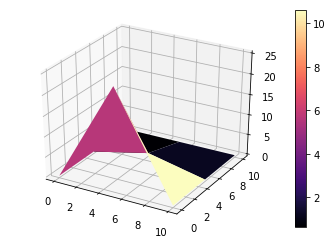

i =  1
yplot
[[0.0, 5.0, 10.0], [0.0, 2.5, 5.0, 7.5, 10.0]]



<Figure size 432x288 with 0 Axes>

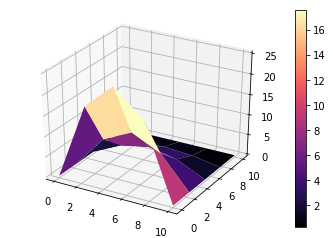

i =  2
yplot
[[0.0, 5.0, 10.0], [0.0, 2.5, 5.0, 7.5, 10.0], [0.0, 1.25, 2.5, 3.75, 5.0, 6.25, 7.5, 8.75, 10.0]]



<Figure size 432x288 with 0 Axes>

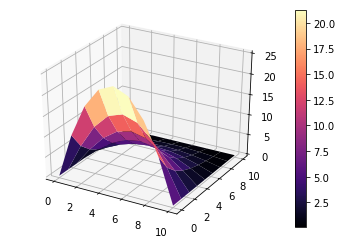

i =  3
yplot
[[0.0, 5.0, 10.0], [0.0, 2.5, 5.0, 7.5, 10.0], [0.0, 1.25, 2.5, 3.75, 5.0, 6.25, 7.5, 8.75, 10.0], [0.0, 0.625, 1.25, 1.875, 2.5, 3.125, 3.75, 4.375, 5.0, 5.625, 6.25, 6.875, 7.5, 8.125, 8.75, 9.375, 10.0]]



<Figure size 432x288 with 0 Axes>

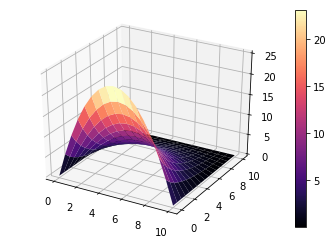

<Figure size 432x288 with 0 Axes>

In [18]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# Convert to x,y and z coords

Z = []
for i in range(nen):
    Z.append(np.reshape(u_solution[i],(node_side[i],node_side[i])))

x_plot = []

for z in range(nen):
    output = []
    for i in range(len(u_x[z])):
        interim = u_x[z][i]
        output.append(interim)
    x_plot.append(output)
    y_plot = x_plot
    print('i = ',z)
    print('yplot')
    print(y_plot)
    print('')
    (X,Y) = np.meshgrid(x_plot[z],y_plot[z])
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    surf = ax.plot_surface(X,Y,Z[z],rstride=1,cstride=1,cmap='magma',lw=0)
    fig.colorbar(surf)
    
    plt.savefig('node_{}.tif'.format(2**(z+1)))
    plt.show()
    plt.clf()
    
#     im = plt.imshow(Z[z], cmap='hot')
#     plt.colorbar(im, orientation='horizontal')
#     plt.show()
    




In [15]:
# compute the midpoints to the approximate solution
uh_midpoint = []
for z in range(nen):
    mid = np.floor(node_side[z]/2).astype(int)
    output = Z[z][mid,mid]
    uh_midpoint.append(output)

$$u(x,y) = \sum_{n=1}^{\infty} \frac{0.2}{\sinh n \pi} \biggl\{ \int_{0}^{10} z(10-z) \sin \frac{n \pi z}{10} dz \biggr \} \sin \frac{n \pi x}{10} \sinh \frac{n \pi (10-y)}{10}$$

In [16]:
# compute exact solution
def u_exact(x,y):
    z = sp.symbols('z')
    output = 0
    for i in range(1,10):
        output1 = 0.2/np.sinh(i*np.pi)
        output2 = sp.integrate(z*(10-z)*sp.sin(i*np.pi*z/10), (z, 0, 10))
        output3 = np.sin(i*np.pi*x/10)
        output4 = np.sinh(i*np.pi*(10-y)/10)
        output += output1*output2*output3*output4
    return output
u_midpoint_exact = (u_exact(5,5))
print(u_exact(5,5))

5.13286467244044


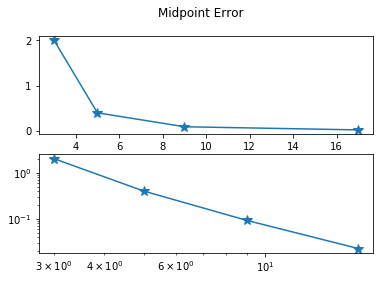

In [17]:
#compute the mid point error

midpoint_error = []
for z in range(nen):
    midpoint_error.append(np.absolute(uh_midpoint[z]-u_midpoint_exact))

#plot
fig, axs = plt.subplots(2)
fig.suptitle('Midpoint Error')
axs[0].plot(node_side[:], midpoint_error[:],markersize=10,marker='*')
axs[1].plot(node_side[:], midpoint_error[:],markersize=10,marker='*')
axs[1].set_yscale('log')
axs[1].set_xscale('log')
plt.show()